In [1]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Imports, as always...

import pandas as pd
import numpy as np

from tqdm import tqdm

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

In [3]:
# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Set RNG.
torch.manual_seed(42)

In [6]:
# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
  )

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Training

This notebook will define and train up GNN architectures using different forms of residual connections; those being: (1) **None**, (2) **fixed-weight**, (3) **freely-learnt** (or unconstrained), (4) **hierarchically-weighted**, and (5) **cluster-keeping**. 

We may also vary the underlying diffusion type; e.g. convolutional, attention-based, etc.

In [8]:
# Invariable hyperparameters.
n_nodes = dataset.data.x.size(0)
model_depths = range(1, 21)
aggregation_function = GCNConv
hid_dim = 64
dropout_ratio = .1
act_fn = F.relu
epochs = 100
max_patience = epochs // 10
lr = 1e-3

## None

In [11]:
# Define a set of GCN models of different depths.
none_models = [
    models.BackboneModel(
        residual_method=None,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
none_stats = {}
for model in tqdm(none_models):
    none_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )

100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


In [15]:
# Save the models' weights.
for model in none_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/none_{depth}.pt')   

In [12]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_none_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in none_models if model.n_layers % 5 == 0
}

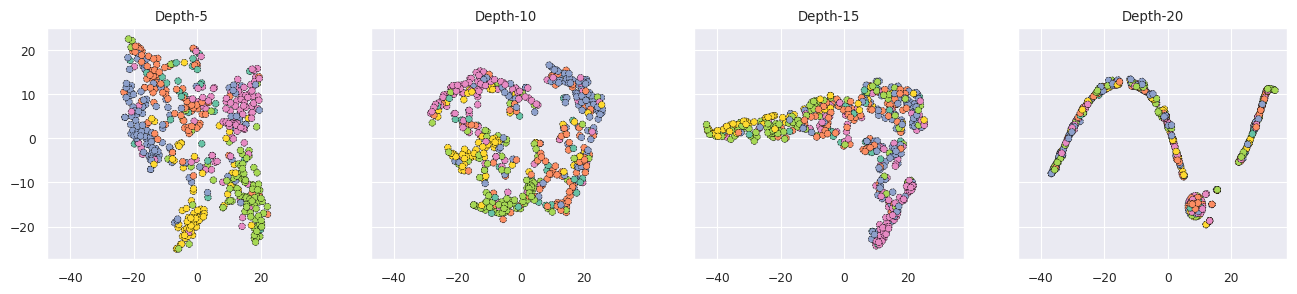

In [14]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_none_model)

# Save figure.
plt.savefig('./figures/convergence/none.pdf', bbox_inches='tight')

## Fixed-weight

We have theoretical results for fixed weights of $1/2$, so that is what we will use here.

In [16]:
# Define a set of GCN models of different depths.
fixed_models = [
    models.BackboneModel(
        residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
fixed_stats = {}
for model in tqdm(fixed_models):
    fixed_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )

100%|██████████| 20/20 [04:50<00:00, 14.53s/it]


In [17]:
# Save the models' weights.
for model in fixed_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/fixed_{depth}.pt')   

In [18]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_fixed_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in fixed_models if model.n_layers % 5 == 0
}

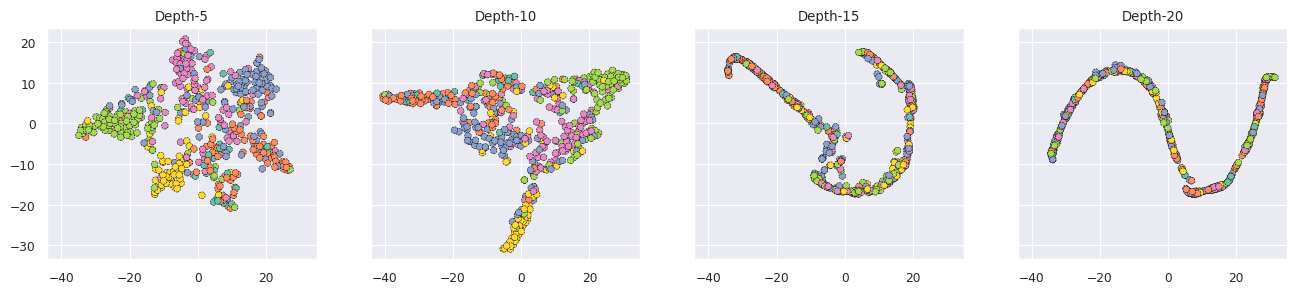

In [20]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_fixed_model)

# Save figure.
plt.savefig('./figures/convergence/fixed.pdf', bbox_inches='tight')

## Freely-learnt

In [ ]:
# Define a set of GCN models of different depths.
free_models = [
    models.BackboneModel(
        residual_method=models.FreeRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
free_stats = {}
for model in tqdm(free_models):
    free_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=False,
        verbose=False
    )
    
    # Save the model weights as we go.
    torch.save(model.state_dict(), f'./models/gcn/free_{model.n_layers}.pt')   

In [29]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_free_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in free_models if model.n_layers % 5 == 0
}

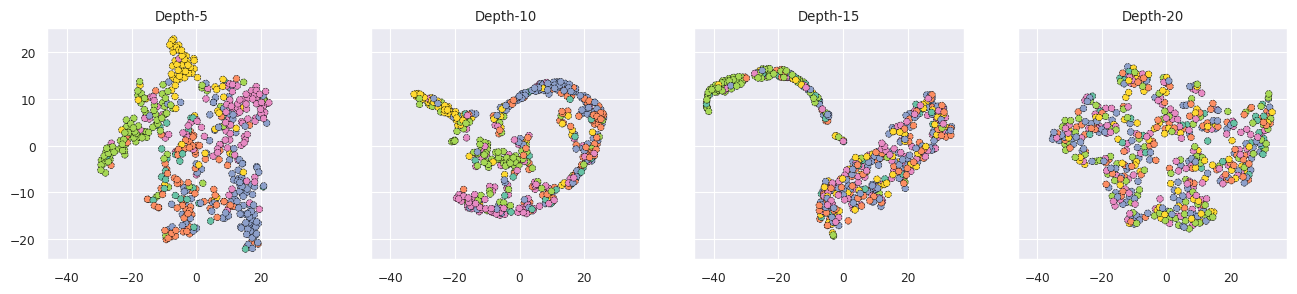

In [31]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_free_model)

# Save figure.
plt.savefig('./figures/convergence/free.pdf', bbox_inches='tight')

## Hierarchically-weighted

In [17]:
# Define a set of GCN models of different depths.
hierarchical_models = [
    models.BackboneModel(
        residual_method=models.HierarchicalRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn
    )
    for depth in model_depths
]

# Train them.
hierarchical_stats = {}
for model in hierarchical_models:
    hierarchical_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=True,
        verbose=False
    )

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_hierarchical_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in hierarchical_models
}

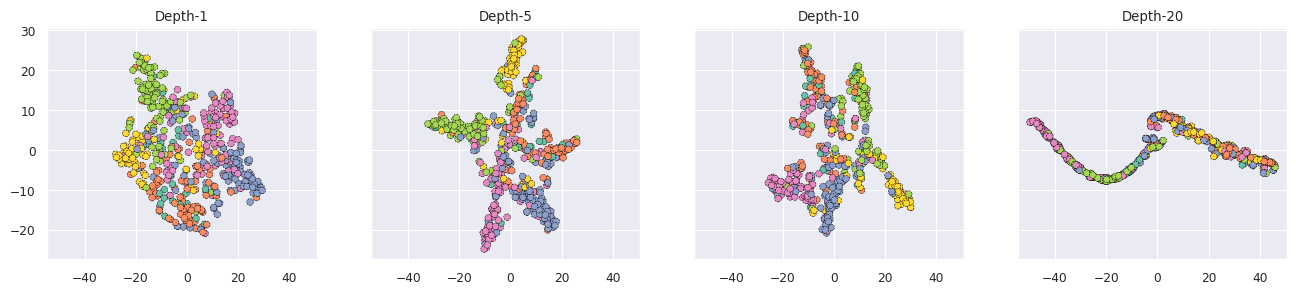

In [41]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_hierarchical_model)

# Save figure.
plt.savefig('./figures/convergence/hierarchical.pdf', bbox_inches='tight')

## Cluster-keeping

In [ ]:
# Define a set of GCN models of different depths.
cluster_models = [
    models.BackboneModel(
        residual_method=models.ClusterKeepingRC,
        aggregation_function=aggregation_function,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=hid_dim,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=dropout_ratio,
        act_fn=act_fn,
        L_0=2 # Give an extra layer before cluster keeping.
    )
    for depth in model_depths
]

# Train them.
cluster_stats = {}
for model in cluster_models:
    cluster_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=epochs,
        max_patience=max_patience,
        lr=lr,
        progress_bar=True,
        verbose=False
    )

In [22]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_cluster_model = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in cluster_models
}

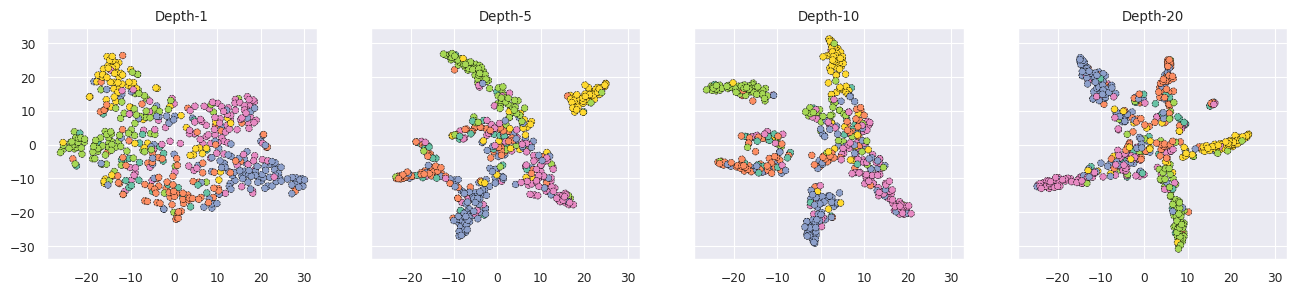

In [40]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_cluster_model)

# Save figure.
plt.savefig('./figures/convergence/cluster.pdf', bbox_inches='tight')

## Saving Those Models

That last one took ages! Let's save it so we don't have to train it again.

In [39]:
for model in none_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/none_{depth}.pt')   
    
# Too big to push to repo.
for model in fixed_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/fixed_{depth}.pt')   
    
# Too big to push to repo.
for model in free_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/free_{depth}.pt')   

# Too big to push to repo.
for model in hierarchical_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/hierarchical_{depth}.pt')   
    
for model in cluster_models:
    depth = model.n_layers
    torch.save(model.state_dict(), f'./models/gcn/cluster_{depth}.pt')   

## Saving the Training Data

In [32]:
for depth, stats in none_stats.items():
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f'./data/gcn/none_{depth}.csv', index=False)
    
for depth, stats in fixed_stats.items():
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f'./data/gcn/fixed_{depth}.csv', index=False)
    
for depth, stats in free_stats.items():
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f'./data/gcn/free_{depth}.csv', index=False)
    
for depth, stats in hierarchical_stats.items():
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f'./data/gcn/hierarchical_{depth}.csv', index=False)
    
for depth, stats in cluster_stats.items():
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f'./data/gcn/cluster_{depth}.csv', index=False)

# Training Curves

In [58]:
from os import walk, path

In [74]:
# Merge all training statistics into a single dataframe.
master_stats_df = pd.DataFrame(columns=['train_acc', 'train_loss', 'val_acc', 'val_loss', 'residual_method', 'model_depth'])

for file in next(walk('./data/gcn'), (None, None, []))[2]:
    stats_df = pd.read_csv(path.join('./data/gcn', file))
    residual_method, model_depth = file[:-4].split('_')
    stats_df['residual_method'] = residual_method
    stats_df['model_depth'] = int(model_depth)
    master_stats_df = pd.concat([master_stats_df, stats_df])

In [75]:
# Add an epoch column.
master_stats_df['epoch'] = list(range(100)) * 20
master_stats_df

,train_acc,train_loss,val_acc,val_loss,residual_method,model_depth,epoch
0,0.191667,1.772310,0.168,1.795599,cluster,1,0
1,0.333333,1.746219,0.190,1.787844,cluster,1,1
2,0.441667,1.720325,0.222,1.780173,cluster,1,2
3,0.591667,1.694634,0.244,1.772592,cluster,1,3
4,0.666667,1.669150,0.272,1.765098,cluster,1,4
...,...,...,...,...,...,...,...
95,1.000000,0.011748,0.608,1.857154,none,5,95
96,1.000000,0.015973,0.608,1.858296,none,5,96
97,1.000000,0.014706,0.606,1.846747,none,5,97
98,1.000000,0.012213,0.608,1.832322,none,5,98


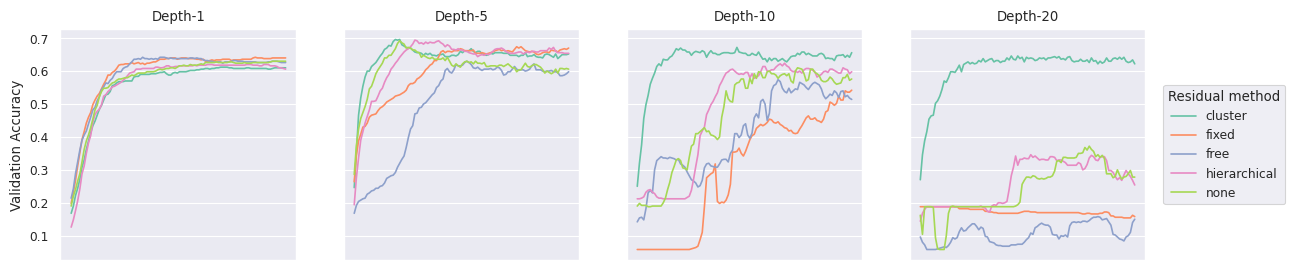

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharex='all', sharey='all')

for ax, depth in zip(axes, sorted(master_stats_df.model_depth.unique())):
    sns.lineplot(
        data=master_stats_df[master_stats_df['model_depth'] == depth],
        x='epoch', y='val_acc',
        hue='residual_method',
        palette='Set2',
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(f'Depth-{depth}')
    
axes[0].set_ylabel('Validation Accuracy')
    
axes[-1].legend(
    bbox_to_anchor=(1.05, .5),
    loc='center left',
    title='Residual method'
)

# Save figure.
plt.savefig('./figures/curves/models-val-acc-by-depth.pdf', bbox_inches='tight')

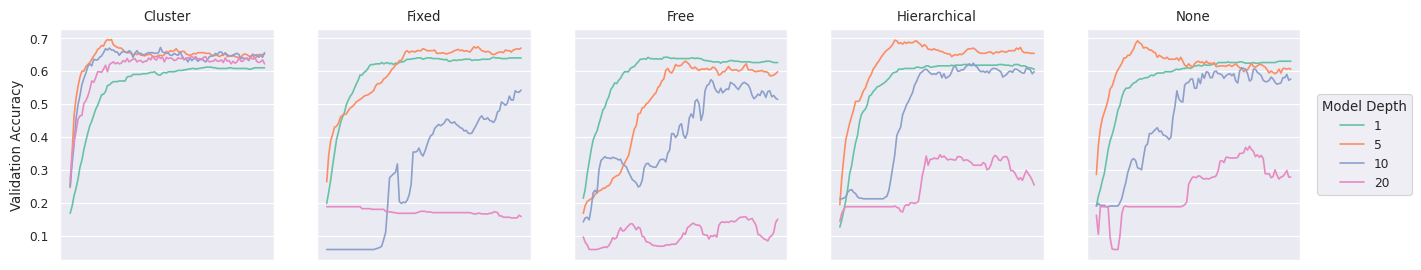

In [114]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex='all', sharey='all')

for ax, method in zip(axes, sorted(master_stats_df.residual_method.unique())):
    sns.lineplot(
        data=master_stats_df[master_stats_df['residual_method'] == method],
        x='epoch', y='val_acc',
        hue='model_depth',
        palette='Set2',
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(method.capitalize())
    
axes[0].set_ylabel('Validation Accuracy')
    
axes[-1].legend(
    bbox_to_anchor=(1.05, .5),
    loc='center left',
    title='Model Depth'
)

# Save figure.
plt.savefig('./figures/curves/depth-val-acc-by-model.pdf', bbox_inches='tight')

In [124]:
a = master_stats_df[master_stats_df['residual_method'] == 'cluster']
a[a['model_depth'] == 20]

,train_acc,train_loss,val_acc,val_loss,residual_method,model_depth,epoch
0,0.300000,1.784407,0.270,1.755036,cluster,20,0
1,0.358333,1.716897,0.346,1.721033,cluster,20,1
2,0.541667,1.550025,0.388,1.716497,cluster,20,2
3,0.650000,1.528444,0.416,1.678404,cluster,20,3
4,0.758333,1.454539,0.454,1.658831,cluster,20,4
...,...,...,...,...,...,...,...
95,1.000000,0.027162,0.630,1.452087,cluster,20,95
96,1.000000,0.027011,0.626,1.530976,cluster,20,96
97,1.000000,0.028082,0.628,1.510165,cluster,20,97
98,1.000000,0.024186,0.634,1.499665,cluster,20,98


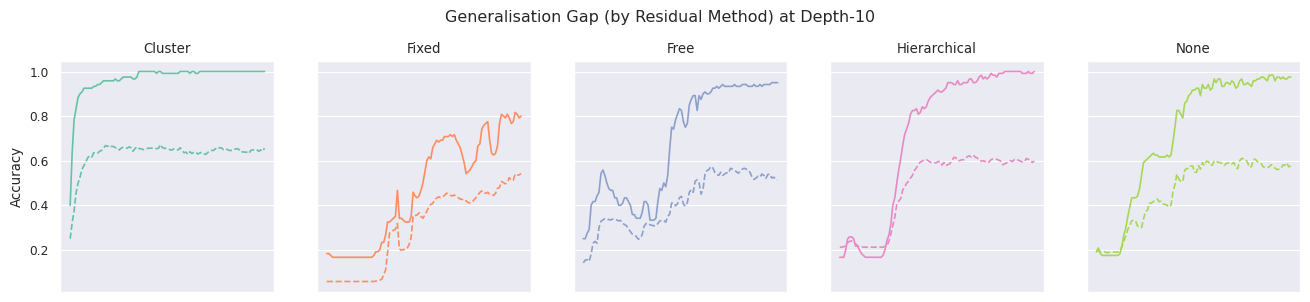

In [134]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex='all', sharey='all')

colours = sns.color_palette('Set2', 5)
for i, (ax, method) in enumerate(zip(axes, sorted(master_stats_df.residual_method.unique()))):
    data = master_stats_df[master_stats_df['residual_method'] == method]
    data = data[data['model_depth'] == 10]
    sns.lineplot(
        data=data,
        x='epoch', y='train_acc',
        color=colours[i],
        ax=ax
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_acc',
        linestyle='--', color=colours[i],
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(method.capitalize())
    
axes[0].set_ylabel('Accuracy')
fig.suptitle('Generalisation Gap (by Residual Method) at Depth-10', y=1.05)

Text(0.5, 1.05, 'Generalisation Gap (by Residual Method) at Depth-10')

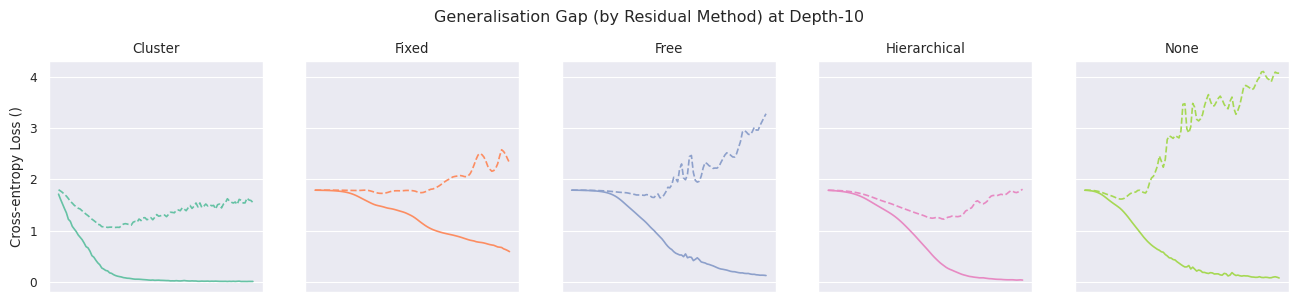

In [136]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex='all', sharey='all')

colours = sns.color_palette('Set2', 5)
for i, (ax, method) in enumerate(zip(axes, sorted(master_stats_df.residual_method.unique()))):
    data = master_stats_df[master_stats_df['residual_method'] == method]
    data = data[data['model_depth'] == 10]
    sns.lineplot(
        data=data,
        x='epoch', y='train_loss',
        color=colours[i],
        ax=ax
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_loss',
        linestyle='--', color=colours[i],
        ax=ax
    )

    # Remove clutter.
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('')

    # Add titles.
    ax.set_title(method.capitalize())
    
axes[0].set_ylabel('Cross-entropy Loss')
fig.suptitle('Generalisation Gap (by Residual Method) at Depth-10', y=1.05)

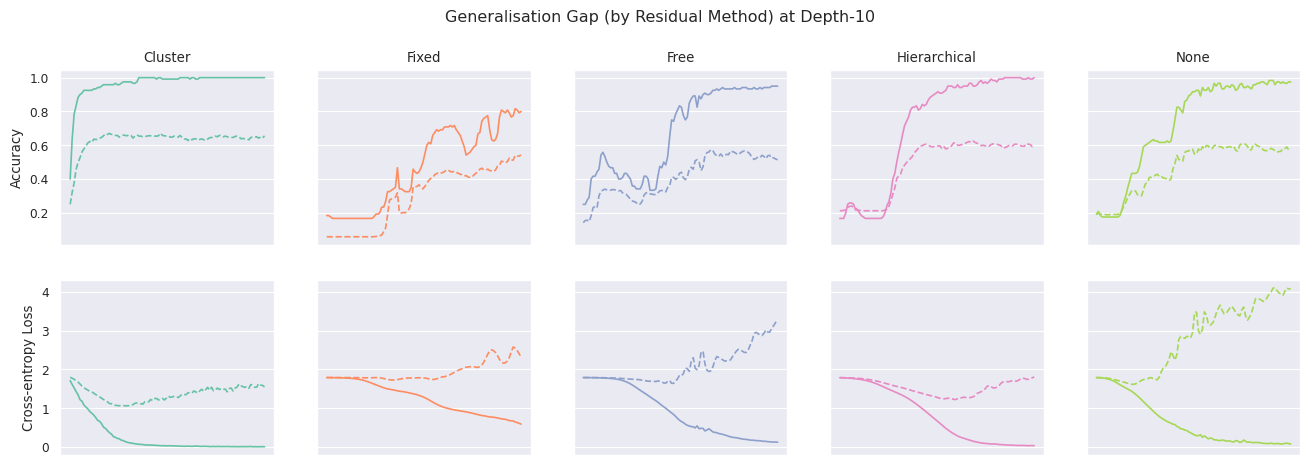

In [140]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5), sharex='all', sharey='row')

colours = sns.color_palette('Set2', 5)
for i, method in enumerate(sorted(master_stats_df.residual_method.unique())):
    data = master_stats_df[master_stats_df['residual_method'] == method]
    data = data[data['model_depth'] == 10]
    sns.lineplot(
        data=data,
        x='epoch', y='train_acc',
        color=colours[i],
        ax=axes[0][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_acc',
        linestyle='--', color=colours[i],
        ax=axes[0][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='train_loss',
        color=colours[i],
        ax=axes[1][i]
    )
    sns.lineplot(
        data=data,
        x='epoch', y='val_loss',
        linestyle='--', color=colours[i],
        ax=axes[1][i]
    )

    # Remove clutter.
    axes[1][i].set_xlabel('')
    axes[1][i].set_xticks([])

    # Add titles.
    axes[0][i].set_title(method.capitalize())
  
axes[0][0].set_ylabel('Accuracy')  
axes[1][0].set_ylabel('Cross-entropy Loss')
fig.suptitle('Generalisation Gap (by Residual Method) at Depth-10', y=1)

# Save figure.
plt.savefig('./figures/curves/generalisation-gap-by-model.pdf', bbox_inches='tight')